In [65]:
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt

In [111]:
df = pd.read_csv('./Miles_Traveled.csv')
df

,DATE,TRFVOLUSM227NFWA
0,1970-01-01,80173.0
1,1970-02-01,77442.0
2,1970-03-01,90223.0
3,1970-04-01,89956.0
4,1970-05-01,97972.0
...,...,...
583,2018-08-01,286608.0
584,2018-09-01,260595.0
585,2018-10-01,282174.0
586,2018-11-01,258590.0


In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588 entries, 0 to 587
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DATE              588 non-null    object 
 1   TRFVOLUSM227NFWA  588 non-null    float64
dtypes: float64(1), object(1)
memory usage: 9.3+ KB


In [113]:
# rename column for prophet
df.columns = ['ds','y']

In [114]:
# transform to datetime format
df['ds'] = pd.to_datetime(df['ds'])

<AxesSubplot:xlabel='ds'>

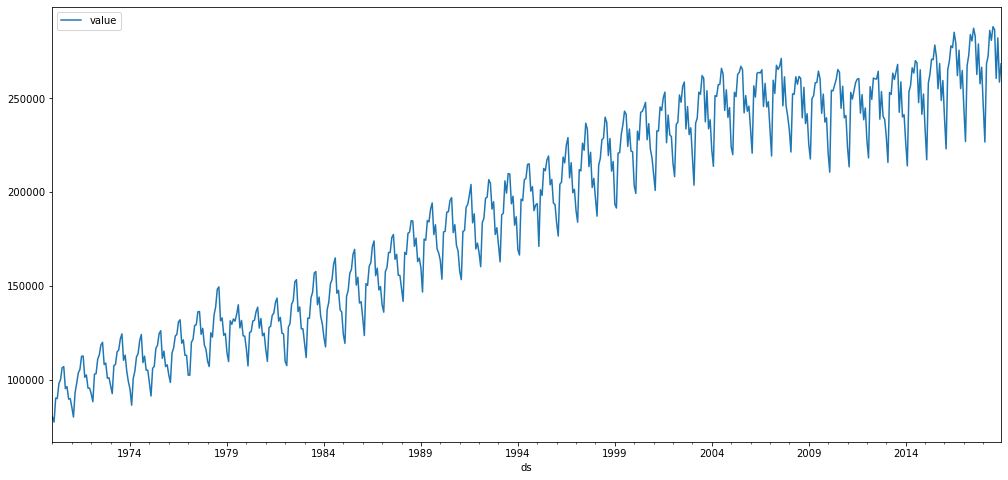

In [132]:
df.plot(x='ds',y="y", figsize=(17,8), label='value')

In [121]:
# check missing values 
print(len(df))
df.isna().any()

588


ds    False
y     False
dtype: bool

## Decompose

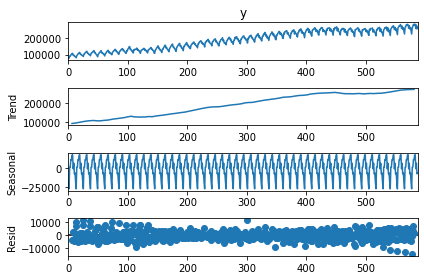

In [141]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['y'], period=12)
result.plot()
plt.show()

<AxesSubplot:>

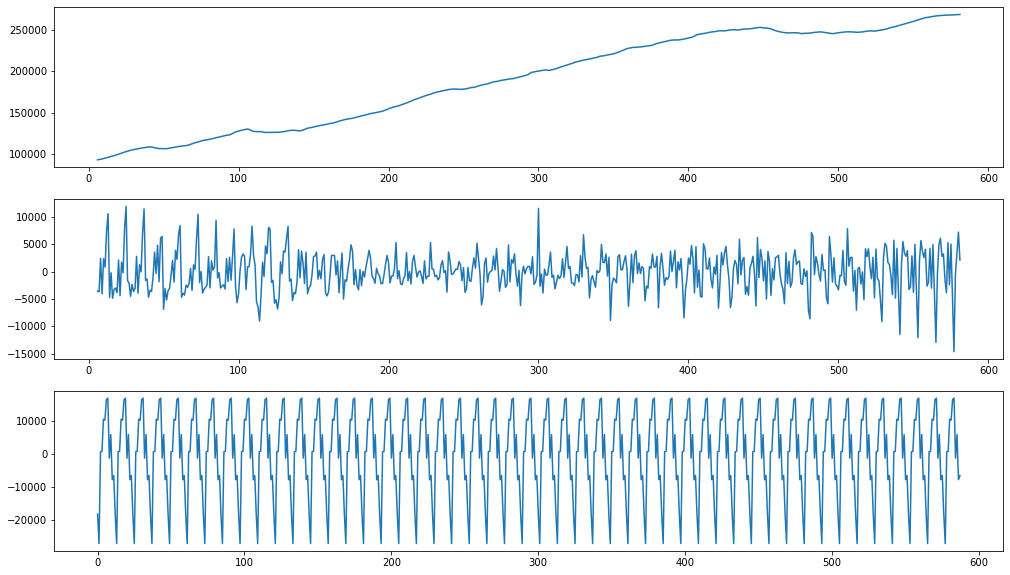

In [142]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(17,10))
result.trend.plot(ax=ax1)
result.resid.plot(ax=ax2)
result.seasonal.plot(ax=ax3)

## split dataset in train test

In [74]:
#len = 588

train = df.iloc[:576]

# 576 = first month of 2018
test = df.iloc[576:]

## predict on train data

In [89]:
#predict the data for the next year (2019)

m = Prophet(seasonality_mode='multiplicative') # Prophet class instanciation. 
m.fit(train) # Fit the Prophet model on train data.

future = m.make_future_dataframe(periods=12, freq='MS') # Make future data frame for the next years (MS = monthly start)
forecast = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [90]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
583,2018-08-01,263504.063429,279241.947878,290355.658488,263425.951772,263558.652325,0.080954,0.080954,0.080954,0.080954,0.080954,0.080954,0.0,0.0,0.0,284835.717110
584,2018-09-01,263650.809567,255414.090878,265831.017553,263521.519818,263726.116826,-0.011556,-0.011556,-0.011556,-0.011556,-0.011556,-0.011556,0.0,0.0,0.0,260603.942450
585,2018-10-01,263792.821959,266165.655643,276753.197268,263616.825932,263904.764987,0.029091,0.029091,0.029091,0.029091,0.029091,0.029091,0.0,0.0,0.0,271466.723858
586,2018-11-01,263939.568097,247641.791637,258152.931841,263717.369009,264103.653803,-0.041323,-0.041323,-0.041323,-0.041323,-0.041323,-0.041323,0.0,0.0,0.0,253032.684120
587,2018-12-01,264081.580489,250027.231112,260660.755817,263788.004021,264283.003384,-0.032022,-0.032022,-0.032022,-0.032022,-0.032022,-0.032022,0.0,0.0,0.0,255625.151534


## visualize trend and seasonality

/Users/anthonycoplo/opt/anaconda3/lib/python3.7/site-packages/fbprophet/plot.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


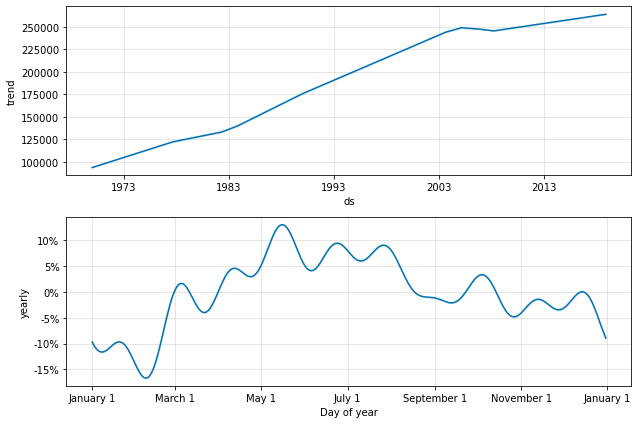

In [91]:
fig = m.plot_components(forecast)

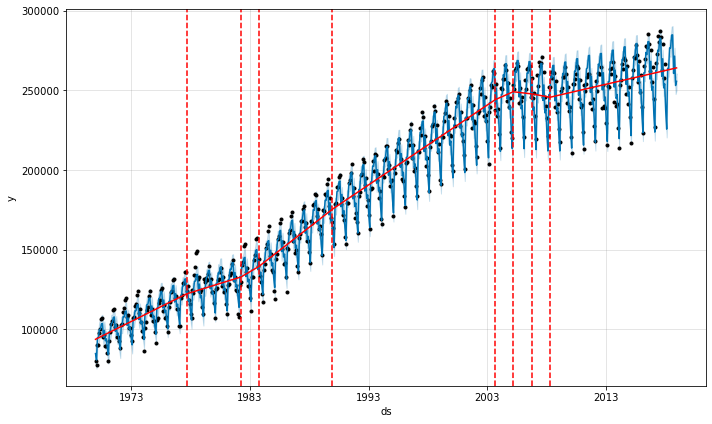

In [104]:
from fbprophet.plot import add_changepoints_to_plot

fig = m.plot(forecast)
cp = add_changepoints_to_plot(fig.gca(),m,forecast)

## visualisation on test data

<AxesSubplot:xlabel='ds'>

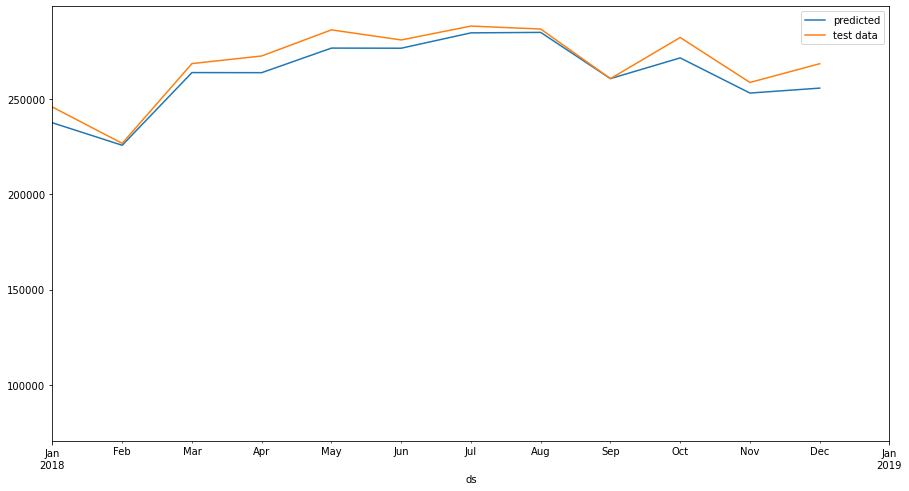

In [93]:
ax = forecast.plot(x="ds",y="yhat",label="predicted",legend=True,figsize=(15,8))
test.plot(x="ds",y="y",label="test data",ax=ax,xlim=("2018-01-01","2019-01-01"),legend=True)

## Evaluate the model

In [94]:
from statsmodels.tools.eval_measures import rmse

In [95]:
pred = forecast.iloc[-12:]['yhat']
pred

576    237438.261474
577    225666.327603
578    263772.268539
579    263722.639471
580    276605.467953
581    276540.145494
582    284594.050911
583    284835.717110
584    260603.942450
585    271466.723858
586    253032.684120
587    255625.151534
Name: yhat, dtype: float64

In [96]:
test['y']

576    245695.0
577    226660.0
578    268480.0
579    272475.0
580    286164.0
581    280877.0
582    288145.0
583    286608.0
584    260595.0
585    282174.0
586    258590.0
587    268413.0
Name: y, dtype: float64

In [145]:
print("RMSE score: ", rmse(pred,test['y']))

RMSE score:  7088.196789682658
